In [274]:
import numpy as np
from matplotlib import pyplot as plt
import glob, operator, time, shutil, scipy, sys, pickle
import pandas as pd

from sklearn import preprocessing
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

import torch

In [4]:
df19 = pd.read_csv('datasets/dim-job-comp/ANL-ALCF-DJC-MIRA_20190101_20191231.csv')
df19.head(3)

,JOB_NAME,COBALT_JOBID,MACHINE_NAME,QUEUED_TIMESTAMP,QUEUED_DATE_ID,START_TIMESTAMP,START_DATE_ID,END_TIMESTAMP,END_DATE_ID,USERNAME_GENID,...,IS_SUBBLOCK,IS_SUBBLOCK_ONLY,IS_MULTILOCATION_ONLY,IS_MULTILOCATION_SUBBLOCK,IS_CONSECUTIVE_ONLY,IS_SINGLE_ONLY,IS_NO_TASKS,IS_OTHER,OVERBURN_CORE_HOURS,IS_OVERBURN
0,1720732.mira,1720732,mira,2018-12-23 15:53:14,20181223,2018-12-31 16:39:30,20181231,2019-01-01 06:04:09,20190101,35420899249343,...,0,0,0,0,0,0,0,1,1.757785e+06,1
1,1724537.mira,1724537,mira,2018-12-31 15:40:17,20181231,2019-01-01 06:10:12,20190101,2019-01-01 06:11:50,20190101,53125484265911,...,0,0,0,0,0,0,0,1,0.000000e+00,0
2,1720959.mira,1720959,mira,2018-12-24 01:36:21,20181224,2019-01-01 06:08:06,20190101,2019-01-01 06:31:33,20190101,25289003749046,...,0,0,0,0,0,0,0,1,0.000000e+00,0


In [208]:
with open('jid2exe-19.pkl', 'rb') as handle:
    jid2exe = pickle.load(handle)

In [255]:
def select_job_logs(jlog, top_q=5, top_u=20, top_p=20, top_e=10):
    jlog_sel = jlog[jlog.EXIT_CODE == 0]
    sel_cols = ['QUEUED_TIMESTAMP', 'USERNAME_GENID', 'PROJECT_NAME_GENID', 'QUEUE_NAME', 'WALLTIME_SECONDS',\
                'NODES_REQUESTED', 'START_TIMESTAMP', 'END_TIMESTAMP', 'COBALT_JOBID', 'EXECUTABLE_GENID',\
                'RUNTIME_SECONDS']
    jlog_sel = jlog_sel[sel_cols]
    
    top_queues = jlog_sel.QUEUE_NAME.value_counts().head(top_q).keys()
    _q_mask = jlog_sel.QUEUE_NAME == top_queues[0]
    for _q in top_queues[1:]:
        _q_mask = _q_mask | (jlog_sel.QUEUE_NAME == _q)
    jlog_sel = jlog_sel[_q_mask]
    
    top_usr = jlog_sel.USERNAME_GENID.value_counts().head(top_u).keys()
    _u_mask = jlog_sel.USERNAME_GENID == top_usr[0]
    for _u in top_usr[1:]:
        _u_mask = _u_mask | (jlog_sel.USERNAME_GENID == _u)
    jlog_sel = jlog_sel[_u_mask]
    
    top_prj = jlog_sel.PROJECT_NAME_GENID.value_counts().head(top_p).keys()
    _p_mask = jlog_sel.PROJECT_NAME_GENID == top_prj[0]
    for _p in top_prj[1:]:
        _p_mask = _p_mask | (jlog_sel.PROJECT_NAME_GENID == _p)
    jlog_sel = jlog_sel[_p_mask]
    
    top_exe = jlog_sel.EXECUTABLE_GENID.value_counts().head(top_e).keys()
    _e_mask = jlog_sel.EXECUTABLE_GENID == top_exe[0]
    for _e in top_exe[1:]:
        _e_mask = _e_mask | (jlog_sel.EXECUTABLE_GENID == _e)
    jlog_sel = jlog_sel[_e_mask]
    
#     jlog_sel['RUNTIME_SECONDS'] = [(pd.to_datetime(_e) - pd.to_datetime(_s)).total_seconds() for \
#                                    _s, _e in zip(jlog_sel.START_TIMESTAMP, jlog_sel.END_TIMESTAMP)]
    jlog_sel['QUEUED_HOUR'] = [pd.to_datetime(_dts).round('2h').hour for _dts in jlog_sel.QUEUED_TIMESTAMP.values]
    
    return jlog_sel


def insert_exe_id(jlog, ):
    with open('jid2exe-19.pkl', 'rb') as handle:
        jid2exe = pickle.load(handle)
    _jid_mask = np.array([jid2exe.get(_jid) is not None for _jid in jlog.COBALT_JOBID])
    jlog_exeid = jlog[_jid_mask].copy()
    jlog_exeid['EXECUTABLE_GENID'] = [jid2exe[_jid] for _jid in jlog_exeid.COBALT_JOBID]
    return jlog_exeid

jlog_exeid = insert_exe_id(df19)
sel_jlog = select_job_logs(jlog_exeid, top_q=5, top_u=10, top_p=10, top_e=20)
print(sel_jlog.shape)
sel_jlog.head()

(13266, 12)


,QUEUED_TIMESTAMP,USERNAME_GENID,PROJECT_NAME_GENID,QUEUE_NAME,WALLTIME_SECONDS,NODES_REQUESTED,START_TIMESTAMP,END_TIMESTAMP,COBALT_JOBID,EXECUTABLE_GENID,RUNTIME_SECONDS,QUEUED_HOUR
6,2018-12-31 12:26:06,94435408522577,24107861762916,backfill,6000.0,512.0,2019-01-01 06:12:26,2019-01-01 07:36:08,1724462,78489508283552,5022.0,12
7,2018-12-31 11:31:26,94435408522577,80954500977394,prod-short,3600.0,2048.0,2019-01-01 06:58:51,2019-01-01 07:37:48,1724428,68253270195915,2337.0,12
13,2019-01-01 07:37:02,94435408522577,24107861762916,backfill,6000.0,512.0,2019-01-01 07:37:49,2019-01-01 09:00:04,1724837,78489508283552,4935.0,8
22,2019-01-01 09:00:24,94435408522577,24107861762916,backfill,6000.0,512.0,2019-01-01 09:01:00,2019-01-01 10:24:00,1724867,78489508283552,4980.0,10
27,2018-12-31 12:10:37,94435408522577,80954500977394,prod-short,3600.0,2048.0,2019-01-01 10:30:06,2019-01-01 11:09:05,1724458,68253270195915,2339.0,12


In [268]:
sel_jlog.EXECUTABLE_GENID.value_counts().head(10)

6495151625245     2101
2436739160882     1668
78489508283552    1507
68253270195915    1383
79859005138212    1187
59547770749566     775
75135514920174     540
51735363785054     537
53061085079359     534
75846758380460     523
Name: EXECUTABLE_GENID, dtype: int64

In [324]:
sel_jlog[sel_jlog.EXECUTABLE_GENID=='6495151625245'].WALLTIME_SECONDS.unique(), sel_jlog[sel_jlog.EXECUTABLE_GENID=='6495151625245'].NODES_REQUESTED.unique()

(array([6600., 5700., 4500.]), array([1024., 8192.]))

In [326]:
def onehot_enc(val):
    u_val = sorted(set(val))
    tbl = {v:i for i, v in enumerate(u_val)}
    ret = np.zeros((len(val), len(u_val)), dtype=np.float32)
    for i, v in enumerate(val):
        ret[i][tbl[v]] = 1
        
    return ret, u_val

def extract_feature(jlog, with_exe=True):
    _qsub_h_enc, _qsub_h_key = onehot_enc(jlog.QUEUED_HOUR.values)
    _usr_enc, _usr_key       = onehot_enc(jlog.USERNAME_GENID.values)
    _proj_enc, _proj_key     = onehot_enc(jlog.PROJECT_NAME_GENID.values)
    _exe_enc, _exe_key       = onehot_enc(jlog.EXECUTABLE_GENID.values)
    _queue_enc, _queue_key   = onehot_enc(jlog.QUEUE_NAME.values)
    _nodes_enc, _nodes_key   = onehot_enc(jlog.NODES_REQUESTED.values.astype(np.uint))

    _qsub_h_key = ['qh%02d' % h for h in _qsub_h_key]
    _usr_key    = ['u%d' % h for h in _usr_key]
    _proj_key   = ['p%d' % h for h in _proj_key]
    _exe_key    = ['e%s' % h for h in _exe_key]
    _nodes_key  = ['nd%05d' % n for n in _nodes_key]
    if with_exe:
        pd_ret      = pd.DataFrame(np.column_stack([_qsub_h_enc, _usr_enc, _proj_enc, _exe_enc, _queue_enc, _nodes_enc]), \
                                   columns=_qsub_h_key + _usr_key + _proj_key + _exe_key + _queue_key + _nodes_key)
    else:
        pd_ret      = pd.DataFrame(np.column_stack([_qsub_h_enc, _usr_enc, _proj_enc, _queue_enc, _nodes_enc]), \
                                   columns=_qsub_h_key + _usr_key + _proj_key + _queue_key + _nodes_key)
    pd_ret['WALLTIME_SECONDS'] = jlog.WALLTIME_SECONDS.values
    pd_ret['RUNTIME_SECONDS']  = jlog.RUNTIME_SECONDS.values
    return pd_ret.astype(np.float32)

pdf_Xy = extract_feature(sel_jlog, with_exe=True)
print(pdf_Xy.shape)
pdf_Xy.head()

(13266, 66)


,qh00,qh02,qh04,qh06,qh08,qh10,qh12,qh14,qh16,qh18,...,nd00256,nd00512,nd00768,nd00896,nd01024,nd02048,nd04096,nd08192,WALLTIME_SECONDS,RUNTIME_SECONDS
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6000.0,5022.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3600.0,2337.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6000.0,4935.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6000.0,4980.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3600.0,2339.0


In [299]:
train_x, test_x, train_y, test_y = train_test_split(pdf_Xy.values[:,:-1], pdf_Xy['RUNTIME_SECONDS'].values, \
                                                    test_size=0.2, random_state=2020)

In [300]:
paras = {'n_estimators'    :[100, 200, 300, 400, 500, 600, 1000][-3:],\
         'max_depth'       :[5, 10, 20, 30, 40, 50][-3:],} 

xgb_mdl = xgb.XGBRegressor()
grid = GridSearchCV(xgb_mdl, paras, n_jobs=16, cv=3)

grid.fit(train_x, train_y)

[13:21:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=16,
             param_grid={'max_depth': [30, 40, 50],
                         'n_estimators': [500, 600, 1000]},
            

In [336]:
pred    = grid.best_estimator_.predict(test_x)
error   = pred - test_y
abs_err = np.abs(error)
rel_err = 100. * abs_err / test_y
print(np.percentile(rel_err, 25), np.percentile(rel_err, 50), np.percentile(rel_err, 75), np.percentile(rel_err, 95))
print(np.percentile(abs_err, 25), np.percentile(abs_err, 50), np.percentile(abs_err, 75), np.percentile(abs_err, 95))

1.2915424406528473 6.079347133636475 22.580288887023926 94.66483345031733
50.9073486328125 217.74267578125 976.3309326171875 4026.005908203125


In [ ]:
((pred + 1000) - test_x[:,-1]).tolist()

array([ 91.55786 ,  92.9281  ,  97.109375, ...,  11.609619,  31.895996,
       307.15918 ], dtype=float32)

In [302]:
top_feat_idx = np.argsort(grid.best_estimator_.feature_importances_)[-15:]
pdf_Xy.columns[top_feat_idx]

Index(['e15802821664047', 'u94435408522577', 'u12851169292280', 'nd00768',
       'nd02048', 'nd04096', 'nd00128', 'e864370307356', 'e78489508283552',
       'u25136838771932', 'e62701735209069', 'u61420714371567',
       'WALLTIME_SECONDS', 'nd08192', 'p47977803483595'],
      dtype='object')

In [303]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## NN based model

In [304]:
class dense(torch.nn.Module):
    def __init__(self, in_sz):
        super().__init__()
        self.dense_ops = []
        dense_out_chs = (2048, 1024, 512, 256)
        dense_in_chs  = (in_sz, ) + dense_out_chs[:-1]
        for ic, oc in zip(dense_in_chs, dense_out_chs):
            self.dense_ops += [
                            torch.nn.Linear(ic, oc),
                            torch.nn.LeakyReLU(negative_slope=0.01),                
            ]
        self.dense_ops += [torch.nn.Linear(dense_out_chs[-1], 1), ]
                
        self.dense_layers = torch.nn.Sequential(*self.dense_ops)
        
    def forward(self, x):
        _out = x
        for layer in self.dense_layers:
            _out = layer(_out)
        return _out


dense_mdl = dense(in_sz=pdf_Xy.shape[1]-1)
# summary(dense_mdl, input_size=(pdf_Xy.shape[1]-1, ), device=torch.device('cpu'), )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dense_mdl.parameters(), lr=3e-4)
    
mb_sz = 32
for epoch in range(10001):
    time_it_st = time.time()
    mb_idx = np.random.randint(0, train_x.shape[0], mb_sz)
    X_mb   = torch.from_numpy(train_x[mb_idx, :])
    y_mb   = torch.from_numpy(np.expand_dims(train_y[mb_idx], -1))
    
    optimizer.zero_grad()
    pred = dense_mdl.forward(X_mb)
    loss = criterion(pred, y_mb)
    loss.backward()
    optimizer.step() 
    
    if epoch % 1000 == 0:
        itr_prints = '[Info] @ %.1f Epoch: %05d, gloss: %.2f, elapse: %.2fs/itr' % (\
                     time.time(), epoch, loss.cpu().detach().numpy(), (time.time() - time_it_st), )
        print(itr_prints)

[Info] @ 1582745045.4 Epoch: 00000, gloss: 52490992.00, elapse: 0.03s/itr
[Info] @ 1582745067.1 Epoch: 01000, gloss: 11567170.00, elapse: 0.02s/itr
[Info] @ 1582745090.3 Epoch: 02000, gloss: 4958344.00, elapse: 0.03s/itr
[Info] @ 1582745117.8 Epoch: 03000, gloss: 15598517.00, elapse: 0.03s/itr
[Info] @ 1582745145.3 Epoch: 04000, gloss: 14756550.00, elapse: 0.03s/itr
[Info] @ 1582745170.7 Epoch: 05000, gloss: 13463319.00, elapse: 0.02s/itr
[Info] @ 1582745196.7 Epoch: 06000, gloss: 8976085.00, elapse: 0.03s/itr
[Info] @ 1582745222.9 Epoch: 07000, gloss: 7664085.50, elapse: 0.03s/itr
[Info] @ 1582745249.1 Epoch: 08000, gloss: 11935786.00, elapse: 0.02s/itr
[Info] @ 1582745275.6 Epoch: 09000, gloss: 4264433.00, elapse: 0.03s/itr
[Info] @ 1582745302.7 Epoch: 10000, gloss: 9340953.00, elapse: 0.03s/itr


In [305]:
with torch.no_grad():
    pred= dense_mdl.forward(torch.from_numpy(test_x))
abs_err = np.abs(pred - test_y)
rel_err = 100. * abs_err / test_y
np.percentile(rel_err, 25), np.percentile(rel_err, 50), np.percentile(rel_err, 75)

(26.816526412963867, 54.243309020996094, 89.8796615600586)

## t-SNE embedding study

In [312]:
tsne_obj = TSNE(n_components=2, random_state=2019)
X_embedded = tsne_obj.fit_transform(preprocessing.scale(pdf_Xy.values[:, :-1]))
X_embedded.shape, tsne_obj.kl_divergence_, tsne_obj.n_iter_

/Users/zliu/usr/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/zliu/usr/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


((13266, 2), -0.3598918914794922, 999)

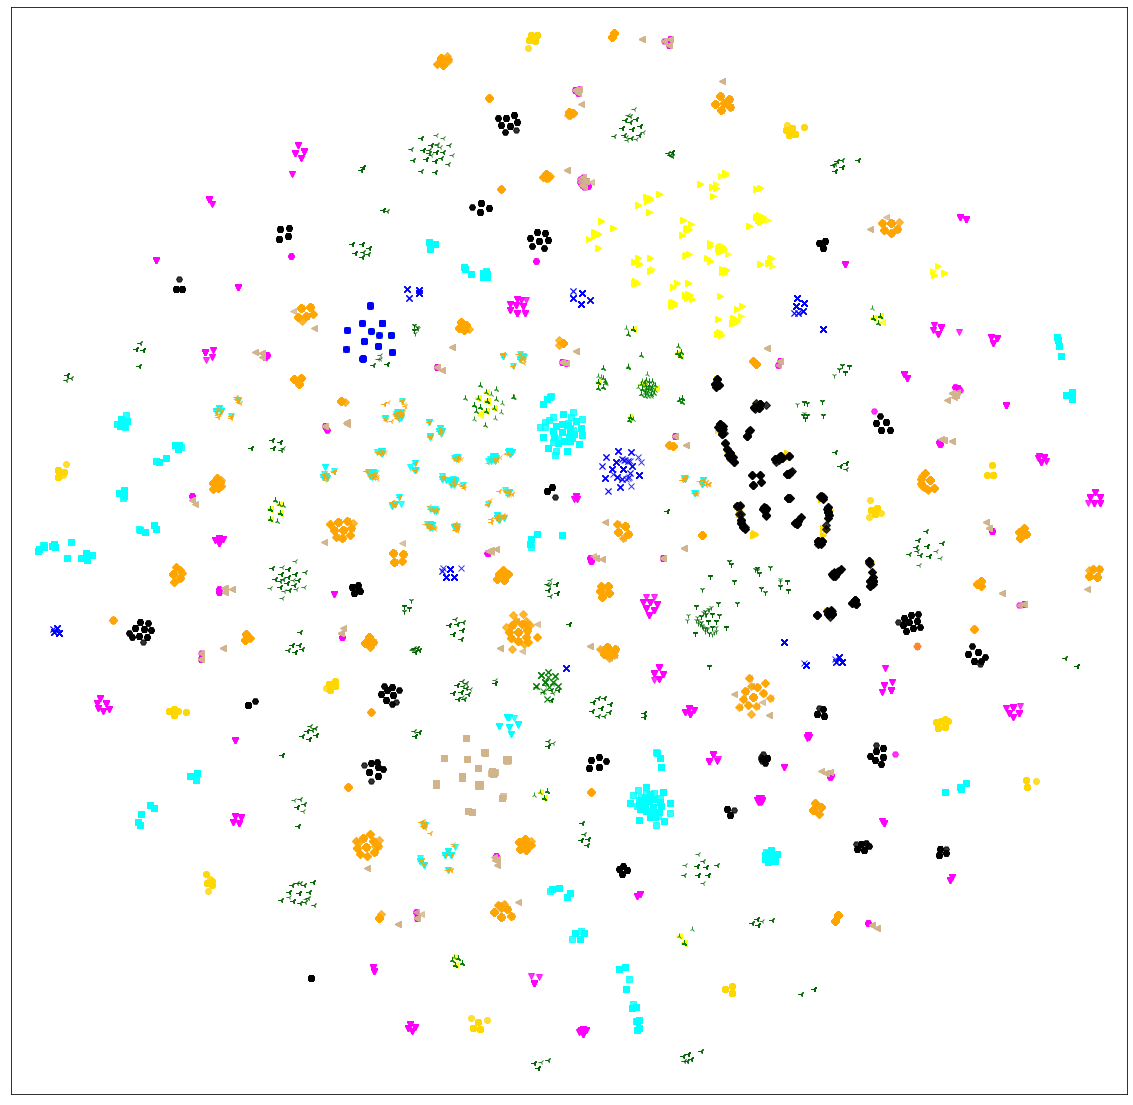

In [313]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=3, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx % len(markers)], alpha=.8, color=colors[_idx % len(colors)], markersize=6, label = _idn[:])
        _other_grp |= (exe_idn == _idn)
#         print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
#     plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=False, framealpha=0.5, fontsize=14)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()

t_sne_vis_by_group(X_embedded, sel_jlog.EXECUTABLE_GENID, topn=20, ofn='tsne-exename.png')